# Training samples

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)

In [4]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [5]:
non_training_attributes = ['changeset_id', 'changeset_harmful']

In [6]:
path = '../downloads/dataset/'

In [7]:
training = pd.read_csv(path + 'training.csv')
validation = pd.read_csv(path + 'validation.csv')

In [8]:
training[pd.isnull(training).any(axis=1)]

,changeset_id,changeset_harmful,changeset_features_created,changeset_features_modified,changeset_features_deleted,changeset_has_imagery_used,changeset_has_source,changeset_comment_number_of_words,changeset_comment_naughty_words_count,changeset_bbox_area,changeset_non_open_data_source,changeset_comment_special_characters_count,user_name_naughty_words_count,user_name_special_characters_count,user_changesets_count,user_features_count,user_mapping_days_count,user_discussions_count,user_changesets_with_discussions_count,old_user_name_naughty_words_count,old_user_name_special_characters_count,old_user_changesets_count,old_user_features_count,old_user_mapping_days_count,old_user_discussions_count,old_user_changesets_with_discussions_count,feature_version,feature_name_naughty_words_count,feature_days_since_last_edit,feature_primary_tags,feature_area,feature_property_tags,feature_name_translations_count,feature_has_website,feature_has_wikidata,feature_has_wikipedia,feature_tags_created_count,feature_tags_modified_count,feature_tags_deleted_count,feature_tags_distance,feature_similar_tags_count,feature_name_naughty_words_count_old,feature_primary_tags_old,feature_area_old,feature_property_tags_old,feature_name_translations_count_old,feature_has_website_old,feature_has_wikidata_old,feature_has_wikipedia_old,feature_similar_tags_count_old,iD,JOSM,MAPS.ME,Potlatch,Redaction,Vespucci,OsmAnd,Merkaartor,GNOME,aerialway,aeroway,amenity,barrier,boundary,building,craft,emergency,geological,highway,historic,landuse,leisure,man_made,military,natural,office,place,power,public_transport,railway,route,shop,sport,tourism,waterway,aerialway_old,aeroway_old,amenity_old,barrier_old,boundary_old,building_old,craft_old,emergency_old,geological_old,highway_old,historic_old,landuse_old,leisure_old,man_made_old,military_old,natural_old,office_old,place_old,power_old,public_transport_old,railway_old,route_old,shop_old,sport_old,tourism_old,waterway_old,tag_values_popularity_min,tag_values_popularity_max,tag_values_popularity_mean,tag_values_popularity_stddev
4080,45233662,0,0,1,0,0,1,5,0,562,0,2,0,2,13242,2061546,1169,179,161,0,2,13242,2061546,1169,179,161,16,0,0,1,NaN,7,1,0,0,1,0,0,0,0,0,0,1,242167,7,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.22,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.0


In [9]:
validation.shape

(3049, 115)

In [10]:
validation.dropna().shape

(3049, 115)

In [11]:
training.shape

(7114, 115)

In [12]:
training.dropna().shape

(7113, 115)

In [13]:
training = training.dropna()

In [14]:
scores = list()
sample_sizes = list(range(250, training.shape[0], 250))
index = []
for sample_size in sample_sizes:
    temp = training.sample(sample_size)
    
    # Prepare datasets for model.
    X = temp.drop(non_training_attributes, axis=1)
    y = temp['changeset_harmful']

    vX = validation.drop(non_training_attributes, axis=1)
    vy = validation['changeset_harmful']

    # Train model on scaled training dataset.
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    model = GradientBoostingClassifier(n_estimators=700, learning_rate=0.1, max_depth=5, max_features='log2', random_state=5).fit(X_scaled, y)

    # Performance on validation dataset.
    vX_scaled = scaler.transform(vX)
    vy_model = model.predict(vX_scaled)
    
    score = [metric(vy, vy_model) for metric in [metrics.precision_score, metrics.recall_score, metrics.f1_score, metrics.roc_auc_score]]
    index.append(temp.shape[0])
    scores.append(score)

In [15]:
scores = pd.DataFrame(scores, columns=['precision_score', 'recall_score', 'f1_score', 'roc_auc_score'], index=index)
print(scores.shape)
scores.head()

(28, 4)


,precision_score,recall_score,f1_score,roc_auc_score
250,0.99,0.78,0.87,0.89
500,0.97,0.79,0.87,0.89
750,0.97,0.79,0.87,0.89
1000,0.98,0.79,0.88,0.89
1250,0.95,0.82,0.88,0.90


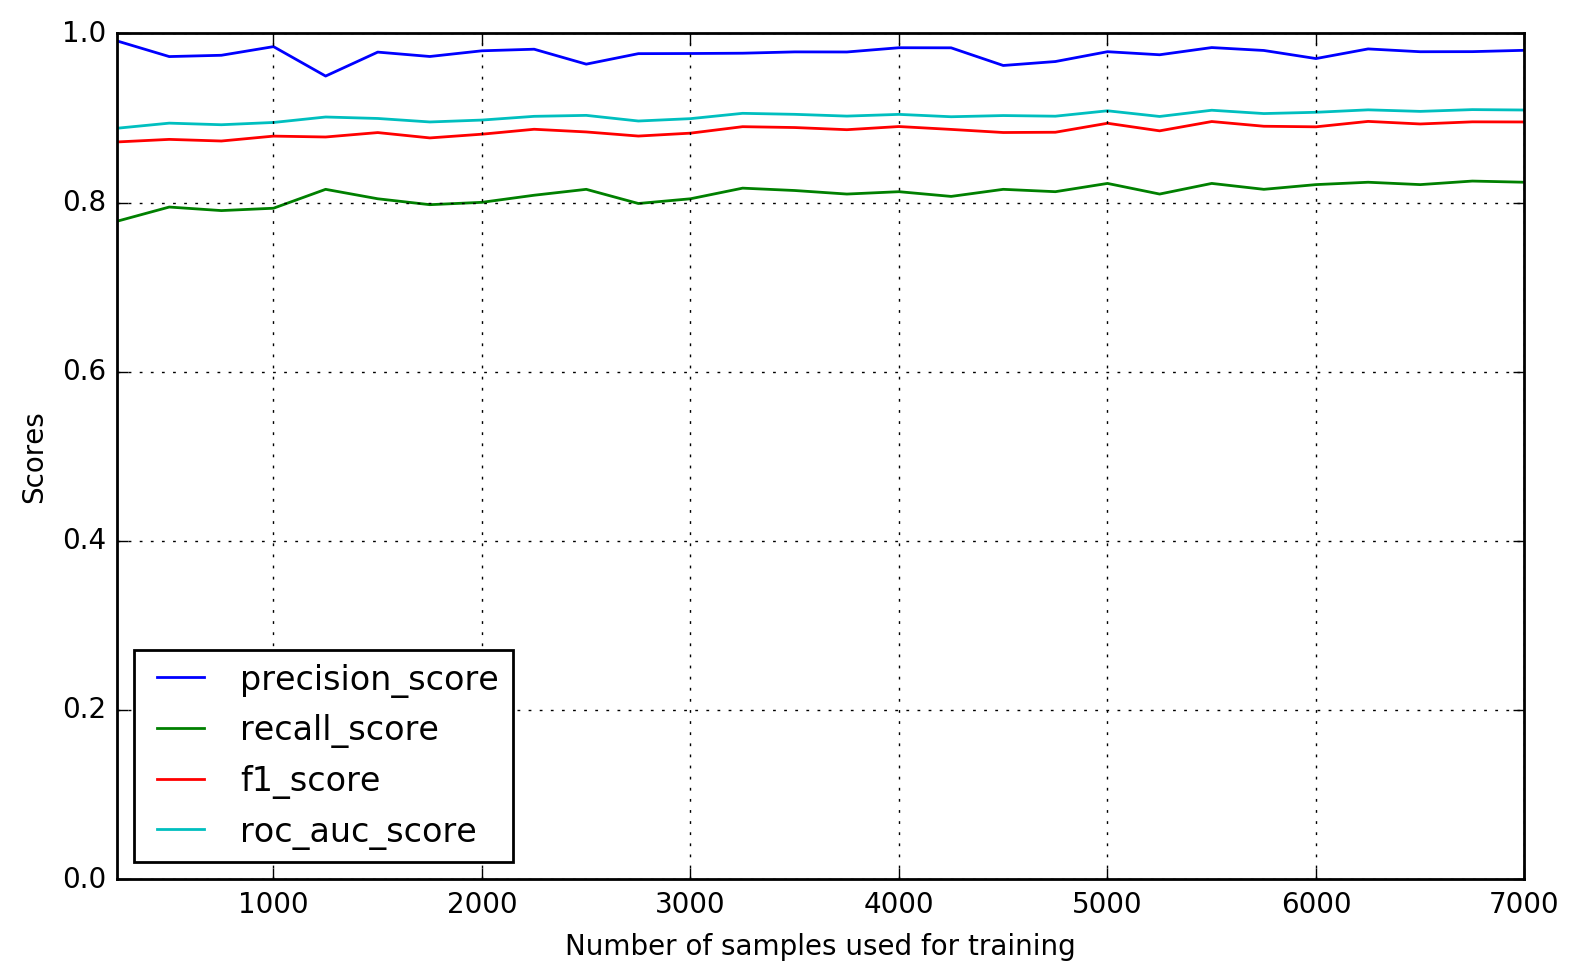

In [16]:
axes = scores.plot(figsize=(8, 5))
axes.set_xlabel('Number of samples used for training')
axes.set_ylabel('Scores')
axes.set_ylim(0, 1)
# axes.set_xticks(np.arange(0, 100, 10))
plt.grid()
plt.tight_layout()